# Source
https://observablehq.com/@heytitle/stein-variational-gradient-descent

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

In [2]:
def RBF(lengthscale=1.0):
    return lambda x1, x2: jnp.exp(-0.5*jnp.sum((x1-x2)**2) / lengthscale**2)

# Stein Variational Gradient Descent (SVGD)

In [3]:
def svgd(kernel, scorefn, num_iterations, num_particles, step_size=1e-2, cb=lambda x: None, every=10):
    """Stein Variational Gradient Descent."""

    @jax.jit
    def step(x):
        phi = lambda xi: jnp.mean(
            jax.vmap(lambda xj: kernel(xi,xj)*scorefn(xj) + jax.grad(kernel)(xj, xi))(x),
            axis=0
        )
        x = x + step_size * jax.vmap(phi)(x)
        return x
    
    x = jax.random.normal(jax.random.PRNGKey(0), (num_particles, 2)) / 2.0
    for i in range(num_iterations):
        x = step(x)
        if i % every == 0: 
            cb(x)
            
    return x

# Test 1: Gaussian mixture

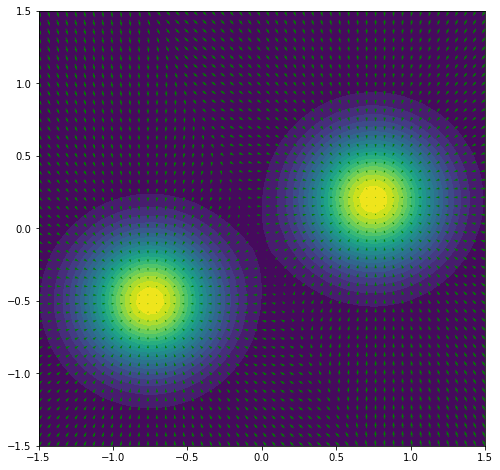

In [4]:
def KDE(kernel, x):
    return lambda xi: jnp.mean(jax.vmap(kernel, (None,0))(xi, x))

def plot_contours_and_scores(p):
    scorefn = jax.grad(lambda x: jnp.log(p(x)))
    plt.figure(figsize=[8, 8])
    x1 = jnp.linspace(-1.5, 1.5, 50)
    x2 = jnp.linspace(-1.5, 1.5, 50)
    x = jnp.stack(jnp.meshgrid(x1, x2), axis=-1).reshape(-1, 2)
    scores = jax.vmap(scorefn)(x)
    scores_norm = jnp.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
    scores_log1p = scores / (scores_norm + 1e-9) * jnp.log1p(scores_norm)
    plt.contourf(x1, x2, jax.vmap(p)(x).reshape(50, 50), levels=20)
    plt.quiver(*x.T, *scores_log1p.T, width=0.002, color='green')
    
def make_gaussian_mixture(lengthscale=0.5):
    centers = jnp.array([[-0.75, -0.5], [0.75, 0.2]])
    kde = KDE(RBF(lengthscale), centers)
    scorefn = jax.grad(lambda x: jnp.log(kde(x)))
    return kde, scorefn

kde_gaussians, scorefn_gaussians = make_gaussian_mixture(lengthscale=0.3)
plot_contours_and_scores(kde_gaussians)

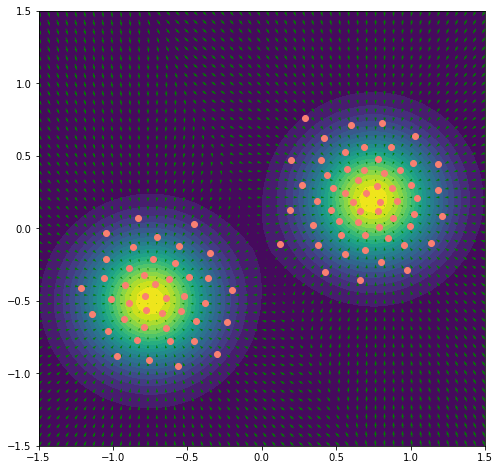

In [5]:
def callback(x):
    clear_output(True)
    plot_contours_and_scores(kde_gaussians)
    plt.scatter(*x.T, color="salmon")
    plt.xlim(-1.5,1.5)
    plt.ylim(-1.5,1.5)
    plt.show()
    
x_opt = svgd(RBF(0.1), scorefn_gaussians, 100, num_particles=100, step_size=0.1, cb=callback)

In [6]:
!pip install gif

  Created wheel for gif: filename=gif-3.0.0-py3-none-any.whl size=4817 sha256=d6b164fc73085d7ede9ac21f25265e3449965be6a33c2b968e9f74e220911ccc
  Stored in directory: /home/demir/.cache/pip/wheels/d8/db/4e/e0ce5209665322902834f4e88fa987f4dfa0c08271368ef098
Successfully built gif
You should consider upgrading via the '/home/demir/anaconda3/envs/pDL/bin/python3.8 -m pip install --upgrade pip' command.


In [7]:
import gif

frames = []

@gif.frame
def plot(x):
    clear_output(True)
    plot_contours_and_scores(kde_gaussians)
    plt.scatter(*x.T, color="salmon")
    plt.xlim(-1.5,1.5)
    plt.ylim(-1.5,1.5)
    plt.axis('off')
    plt.title("SVGD")
    
def callback(x):
    frame = plot(x)
    frames.append(frame)
    
svgd(RBF(0.1), scorefn_gaussians, 150, num_particles=100, step_size=0.1, cb=callback, every=1)
gif.save(frames, 'svgd_gaussian_blobs.gif', duration=5, unit="s", between="startend")

# Test 2: Swiss roll

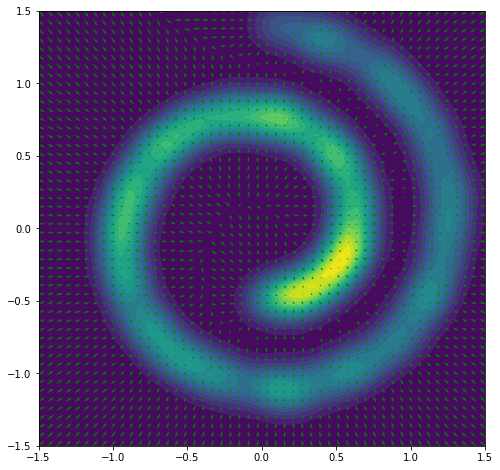

In [8]:
from sklearn.datasets import make_swiss_roll

def sample_swiss_roll(num_samples, noise=1.0):
    x, _= make_swiss_roll(num_samples, noise=noise)
    x = x[:, [0, 2]] / 10.0
    return jnp.array(x)

def make_swiss_score(num_samples=2500, lengthscale=0.1):
    x = sample_swiss_roll(num_samples=num_samples, noise=0.5)
    kde = KDE(RBF(lengthscale), x)
    scorefn = jax.grad(lambda x: jnp.log(kde(x)))
    return kde, scorefn

kde_swiss, scorefn_swiss = make_swiss_score()
plot_contours_and_scores(kde_swiss)

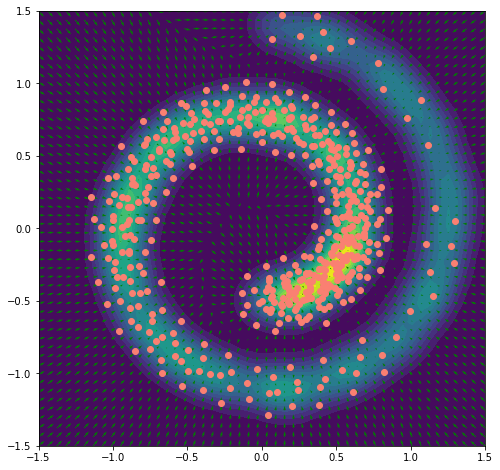

In [9]:
def callback(x):
    clear_output(True)
    plot_contours_and_scores(kde_swiss)
    plt.scatter(*x.T, color="salmon")
    plt.xlim(-1.5,1.5)
    plt.ylim(-1.5,1.5)
    plt.show()
    
x_opt = svgd(RBF(lengthscale=0.1), scorefn_swiss, 100, num_particles=500, step_size=0.1, cb=callback, every=5)

In [10]:
import gif

frames = []

@gif.frame
def plot(x):
    clear_output(True)
    plot_contours_and_scores(kde_swiss)
    plt.scatter(*x.T, color="salmon")
    plt.xlim(-1.5,1.5)
    plt.ylim(-1.5,1.5)
    plt.axis('off')
    plt.title("SVGD")
    
def callback(x):
    frame = plot(x)
    frames.append(frame)
    
svgd(RBF(lengthscale=0.1), scorefn_swiss, 100, num_particles=500, step_size=0.1, cb=callback, every=1)
gif.save(frames, 'svgd_swissroll.gif', duration=5, unit="s", between="startend")